In [365]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from pandas.api.types import is_string_dtype, CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
#from keras.preprocessing.sequence import pad_sequences
#authors note, different version of Keras put pad_sequences in different places, if one doesn't work, please try the other
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.utils.data_utils import pad_sequences
from scikeras.wrappers import KerasRegressor
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix


In [366]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [367]:
#for google colab
#from google.colab import files
#uploaded = files.upload()

In [368]:
#for google colab
#from google.colab import files
#uploaded = files.upload()

In [369]:
country = 'Tunisia'

In [370]:
frdm = pd.read_csv("../data/fh.csv")
#df = pd.read_parquet("../data/full_sent/egypt_full.parquet")
df = pd.read_parquet("../data/roberta_scored_data/tunisia_roberta_scores.parquet")

In [371]:
print(df['keyword'].unique())

['Tunisia']


In [372]:
df = df[df['keyword'] == country]

In [373]:
def select_country(frdm, country):
	frdm = frdm.rename(columns={'fh_country': 'country'})
	frdm_scores = frdm[frdm['country'] == country]
	return frdm_scores

In [374]:
frdm_scores = select_country(frdm, country)
frdm_scores.head()

,Unnamed: 0,country,year,pr,cl,status,fh_total,fh_total_reversed,extended_country_name,GWn,cown,in_GW_system
8016,8017,Tunisia,1972,6,5,NF,11,3,Tunisia,616,616,True
8017,8018,Tunisia,1973,6,5,NF,11,3,Tunisia,616,616,True
8018,8019,Tunisia,1974,6,5,NF,11,3,Tunisia,616,616,True
8019,8020,Tunisia,1975,6,5,NF,11,3,Tunisia,616,616,True
8020,8021,Tunisia,1976,6,5,NF,11,3,Tunisia,616,616,True


In [375]:
df['pub_date'] = pd.to_datetime(df['pub_date'])
# Extract the year
df['year'] = df['pub_date'].dt.year

# Now, merge the two dataframes on the 'year' column
merged_df = pd.merge(df, frdm_scores[['fh_total', 'year', 'status']], on='year', how='left')

In [376]:
merged_df['status'].value_counts()

status
PF    317
F     252
Name: count, dtype: int64

In [377]:
merged_df.head()

,abstract,headline,pub_date,year,section_name,news_desk,keyword,all_text,roberta_scores,roberta_pos,roberta_neg,roberta_neu,fh_total,status
0,The release of Ali Harzi dramatized the lack o...,Lone Suspect Held in Benghazi Attack Is Freed ...,2013-01-08 15:26:13+00:00,2013,World,Foreign,Tunisia,Lone Suspect Held in Benghazi Attack Is Freed ...,"[0.7916475, 0.20278692, 0.005565603]",0.005566,0.791647,0.202787,6.0,PF
1,"Ali Laarayedh, now the interior minister of Tu...",Leading the Tunisian Agency That Once Jailed Him,2013-01-26 01:39:06+00:00,2013,World,Foreign,Tunisia,Leading the Tunisian Agency That Once Jailed H...,"[0.22630417, 0.75236905, 0.02132675]",0.021327,0.226304,0.752369,6.0,PF
2,The prime minister said he would dissolve the ...,Tunisia Moves to Contain Fallout After Opposit...,2013-02-06 09:41:51+00:00,2013,World,Foreign,Tunisia,Tunisia Moves to Contain Fallout After Opposit...,"[0.79256046, 0.2013097, 0.0061297845]",0.006130,0.792560,0.201310,6.0,PF
3,Video and photographs shot by Tunisian activis...,Video of Protests Across Tunisia After an Oppo...,2013-02-06 19:20:43+00:00,2013,Blogs,,Tunisia,Video of Protests Across Tunisia After an Oppo...,"[0.12955186, 0.84961945, 0.020828618]",0.020829,0.129552,0.849619,6.0,PF
4,"Photos from Greece, Syria, Tunisia and Iraq.",Pictures of the Day: Greece and Elsewhere,2013-02-06 23:46:55+00:00,2013,Multimedia/Photos,,Tunisia,Pictures of the Day: Greece and Elsewhere Phot...,"[0.009031875, 0.9411543, 0.04981388]",0.049814,0.009032,0.941154,6.0,PF


In [378]:
# Assuming df is your DataFrame and 'pub_date' is your date column
merged_df = merged_df.set_index('pub_date')
merged_df.head()


,abstract,headline,year,section_name,news_desk,keyword,all_text,roberta_scores,roberta_pos,roberta_neg,roberta_neu,fh_total,status
pub_date,,,,,,,,,,,,,
2013-01-08 15:26:13+00:00,The release of Ali Harzi dramatized the lack o...,Lone Suspect Held in Benghazi Attack Is Freed ...,2013,World,Foreign,Tunisia,Lone Suspect Held in Benghazi Attack Is Freed ...,"[0.7916475, 0.20278692, 0.005565603]",0.005566,0.791647,0.202787,6.0,PF
2013-01-26 01:39:06+00:00,"Ali Laarayedh, now the interior minister of Tu...",Leading the Tunisian Agency That Once Jailed Him,2013,World,Foreign,Tunisia,Leading the Tunisian Agency That Once Jailed H...,"[0.22630417, 0.75236905, 0.02132675]",0.021327,0.226304,0.752369,6.0,PF
2013-02-06 09:41:51+00:00,The prime minister said he would dissolve the ...,Tunisia Moves to Contain Fallout After Opposit...,2013,World,Foreign,Tunisia,Tunisia Moves to Contain Fallout After Opposit...,"[0.79256046, 0.2013097, 0.0061297845]",0.006130,0.792560,0.201310,6.0,PF
2013-02-06 19:20:43+00:00,Video and photographs shot by Tunisian activis...,Video of Protests Across Tunisia After an Oppo...,2013,Blogs,,Tunisia,Video of Protests Across Tunisia After an Oppo...,"[0.12955186, 0.84961945, 0.020828618]",0.020829,0.129552,0.849619,6.0,PF
2013-02-06 23:46:55+00:00,"Photos from Greece, Syria, Tunisia and Iraq.",Pictures of the Day: Greece and Elsewhere,2013,Multimedia/Photos,,Tunisia,Pictures of the Day: Greece and Elsewhere Phot...,"[0.009031875, 0.9411543, 0.04981388]",0.049814,0.009032,0.941154,6.0,PF


In [379]:
# Resample the data to daily frequency
df_daily = merged_df.resample('D').first()

# Fill the NaN values with 0
df_daily = df_daily.fillna(0)
df_daily['all_text'] = df_daily['all_text'].replace(0, 'no_news')

df_daily['status'] = df_daily['status'].replace(0, pd.NA)
df_daily['status'] = df_daily['status'].bfill()
df_daily['status'] = df_daily['status'].ffill()

In [380]:
df_daily['all_text']

pub_date
2011-01-11 00:00:00+00:00    Amid Rioting, Tunisia Closes Universities The ...
2011-01-12 00:00:00+00:00    Protests Spread to Tunisia’s Capital, and a Cu...
2011-01-13 00:00:00+00:00    Tunisia Seethes President Zine el-Abidine Ben ...
2011-01-14 00:00:00+00:00    Tunisia Leader Flees and Prime Minister Claims...
2011-01-15 00:00:00+00:00    In Tunisia, Clashes Continue as Power Shifts a...
                                                   ...                        
2023-11-03 00:00:00+00:00                                              no_news
2023-11-04 00:00:00+00:00                                              no_news
2023-11-05 00:00:00+00:00                                              no_news
2023-11-06 00:00:00+00:00                                              no_news
2023-11-07 00:00:00+00:00    Meloni Says She’ll Send Migrants to Albania. S...
Freq: D, Name: all_text, Length: 4684, dtype: object

In [381]:
articles = []
labels = []


for index, row in df_daily.iterrows():
	labels.append(row['status'])

	token_list = [x for x in row['all_text'].split()]

	articles.append(" ".join(token_list))

In [382]:
# Define some variables
vocab_size = 10000 # max number of words
embedding_dim = 64 # This is the dimension of the Word Vector
max_length = 100 # maximum length of the sequence
trunc_type = 'post' # where to chop off
padding_type = 'post' # where to put the padding
oov_token = '<OOV>'

In [383]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token = oov_token)

In [384]:
# Assume 'articles' is your list of news stories
tokenizer.fit_on_texts(articles)

# Convert the articles to sequences of integers
sequences = tokenizer.texts_to_sequences(articles)

# Pad the sequences so they all have the same length
data = pad_sequences(sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)

# Define the window size
window = 50

# Create an array to hold the expanded features
expanded_features = np.zeros((len(data) - window + 1, window, data.shape[1]))

# For each day's news story
for i in range(window, len(data) + 1):
    # Get the past 'window' days' stories
    expanded_features[i - window] = data[i - window:i]

In [385]:
df_daily['status'].value_counts()

status
F     2402
PF    2282
Name: count, dtype: int64

In [386]:
encoded_column = np.where(df_daily['status'] == 'PF', 1, 0)


In [387]:
print(encoded_column)
expanded_features.shape

[1 1 1 ... 1 1 1]


(4635, 50, 100)

In [388]:
# Assume 'labels' is your list of labels
labels_array = np.array(labels)

# Make sure the labels array has the same first dimension as your features
assert labels_array[window-1:].shape[0] == expanded_features.shape[0]

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(expanded_features, encoded_column[window-1:], test_size=0.2, random_state=42, shuffle=True)

In [389]:
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [390]:
tokenizer.word_index


{'<OOV>': 1,
 'news': 2,
 'no': 3,
 'the': 4,
 'in': 5,
 'of': 6,
 'a': 7,
 'to': 8,
 'and': 9,
 'tunisia': 10,
 'for': 11,
 'that': 12,
 'arab': 13,
 'on': 14,
 'is': 15,
 'tunisian': 16,
 'as': 17,
 'from': 18,
 'with': 19,
 'president': 20,
 'after': 21,
 'tunisia’s': 22,
 'has': 23,
 'an': 24,
 'spring': 25,
 'are': 26,
 'new': 27,
 'at': 28,
 'have': 29,
 'government': 30,
 'democracy': 31,
 'his': 32,
 'was': 33,
 'country': 34,
 'by': 35,
 'who': 36,
 'said': 37,
 'but': 38,
 'it': 39,
 'tunisians': 40,
 'world': 41,
 'party': 42,
 'over': 43,
 'political': 44,
 'its': 45,
 'egypt': 46,
 'islamist': 47,
 'their': 48,
 'attack': 49,
 'revolution': 50,
 'were': 51,
 'state': 52,
 'protests': 53,
 'power': 54,
 'libya': 55,
 'people': 56,
 'will': 57,
 'two': 58,
 'about': 59,
 'more': 60,
 'killed': 61,
 'he': 62,
 'not': 63,
 'minister': 64,
 'be': 65,
 'this': 66,
 'leader': 67,
 'had': 68,
 'been': 69,
 'many': 70,
 'one': 71,
 'u': 72,
 'year': 73,
 'ben': 74,
 'where': 75,
 '

train word vectors

In [391]:
#sentiment_scores = df_selected.values
# Reshape sentiment_scores to have the same number of columns as data
#data_with_scores = np.concatenate([data, sentiment_scores], axis=1)
print(X_train.shape)
print(len(y_train))

(3708, 50, 100)
3708


In [392]:
from tensorflow.keras.layers import Bidirectional

vocab_size = 100  # or more, depending on your data
embedding_dim = 64
max_length = 50

model = Sequential()
#model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(50, 100)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [393]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_32 (Bidirecti  (None, 50, 128)          84480     
 onal)                                                           
                                                                 
 bidirectional_33 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dense_16 (Dense)            (None, 1)                 65        
                                                                 
Total params: 125,761
Trainable params: 125,761
Non-trainable params: 0
_________________________________________________________________


In [394]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2)

history = model.fit(X_train, y_train, validation_data = (X_test, y_test),  batch_size = 128, epochs = 5)

Epoch 1/5
29/29 [==============================] - 147s 2s/step - loss: 0.6055 - accuracy: 0.6893 - val_loss: 0.4766 - val_accuracy: 0.7983
Epoch 2/5
29/29 [==============================] - 14s 492ms/step - loss: 0.3737 - accuracy: 0.8433 - val_loss: 0.3221 - val_accuracy: 0.8511
Epoch 3/5
29/29 [==============================] - 12s 436ms/step - loss: 0.3257 - accuracy: 0.8522 - val_loss: 0.2007 - val_accuracy: 0.9169
Epoch 4/5
29/29 [==============================] - 13s 446ms/step - loss: 0.1859 - accuracy: 0.9204 - val_loss: 0.1273 - val_accuracy: 0.9525
Epoch 5/5
29/29 [==============================] - 10s 352ms/step - loss: 0.1844 - accuracy: 0.9239 - val_loss: 0.1881 - val_accuracy: 0.9277


29/29 [==============================] - 23s 43ms/step


Text(50.722222222222214, 0.5, 'True')

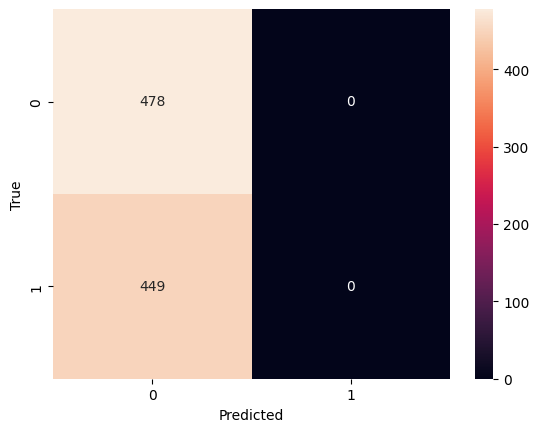

In [395]:
y_pred = model.predict(X_test) 
y_pred = np.argmax(y_pred, axis=1)
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')


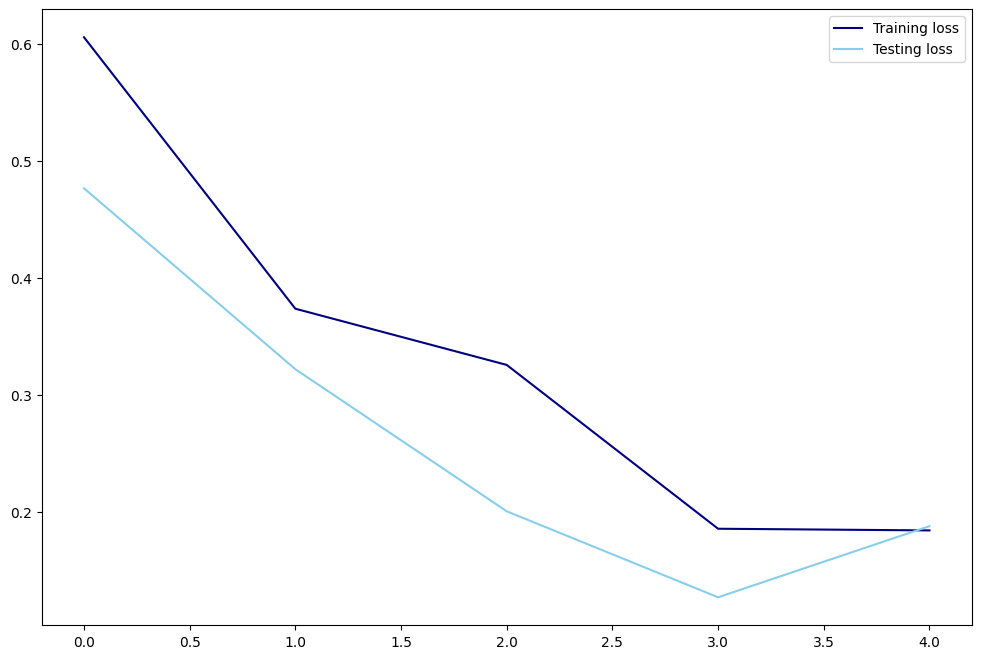

In [396]:
# Visualize the loss
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

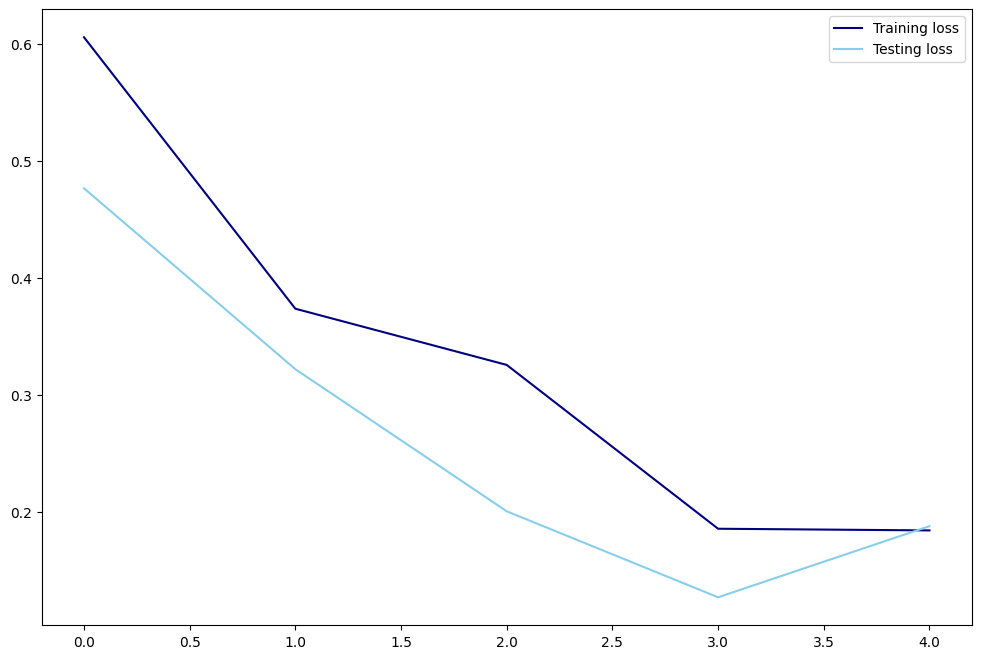

In [397]:
# Visualize the loss
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

In [398]:
# Get the embeddings from the embedding layer
embeddings = model.layers[0].get_weights()[0]

# Create a dictionary to map indices to words
word_to_index = tokenizer.word_index
index_to_word = {v: k for k, v in word_to_index.items()}

# Now you can get the embedding of a word like this:
word = "example"
word_embedding = embeddings[word_to_index[word]]

IndexError: index 2277 is out of bounds for axis 0 with size 100

In [ ]:
word_embedding

array([-0.02270818,  0.04638885, -0.00918608,  0.01880567,  0.02911003,
        0.00385864,  0.04770538, -0.01647489,  0.03811292, -0.04402161,
        0.00353162, -0.02625338, -0.04556441, -0.02418173,  0.03292876,
       -0.01646582,  0.02826924, -0.02207358, -0.04334329, -0.01394787,
        0.00198222, -0.01082713,  0.03528147,  0.02123004, -0.02284766,
        0.02744615,  0.04507652,  0.02539293, -0.00047426, -0.00055699,
       -0.04064018, -0.03228501, -0.0488784 ,  0.02343431, -0.00450666,
        0.01546543,  0.02649575, -0.03827449,  0.01888963,  0.0263534 ,
        0.02175152,  0.01311486,  0.03050259,  0.01900692,  0.0045494 ,
        0.02324464,  0.03395399,  0.01961519, -0.02793471,  0.00659522,
        0.04125473, -0.04515826,  0.01943357, -0.01864521, -0.02914256,
       -0.01288458,  0.03055224,  0.03107135,  0.00040753, -0.01992688,
        0.02807276,  0.0238966 , -0.03495276, -0.01783298,  0.00265012,
        0.0165749 ,  0.00904882, -0.03521918,  0.01849625, -0.02

hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World
hello! World